# First exploratory steps in cocoa daily prices (2022–2025)

This notebook cleans and structures the **ICCO cocoa daily prices** dataset and prepares it for further analysis.

Main questions we can explore after cleaning:
- Is there evidence of **cost pressure** in cocoa prices (trend / volatility)?
- Are there **seasonal patterns** (monthly/quarterly effects)?
- How do **London vs New York futures** relate to the ICCO daily price?

**Study period for this project:** **2022-01-01 to 2025-12-31**.


# Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv


# Load raw data

In [2]:
DATA_PATH = Path(r"/Users/linaabdulsamad/Desktop/Bootcamp/Chocolate/datasets/jl_cocoa_daily_prices_1994-2025.csv")

# The file is semicolon-separated (;) — important!
raw = pd.read_csv(DATA_PATH, sep=";")

raw.head()

,Date,London futures (£ sterling/tonne),New York futures (US$/tonne),ICCO daily price (US$/tonne),ICCO daily price (Euro/tonne)
0,2025-08-07,5401.33,8116.00,7687.97,6605.12
1,2025-08-06,5404.33,7882.67,7553.05,6487.69
2,2025-08-05,5424.00,7878.33,7551.55,6521.90
3,2025-08-04,5272.33,7638.67,7324.64,6335.45
4,2025-08-01,5384.33,7696.33,7422.56,6419.77


# Clean & structure

In [3]:
df = raw.copy()

# 1) Parse date
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# 2) Standardize column names (optional but recommended)
rename_map = {
    "London futures (£ sterling/tonne)": "london_futures_gbp_per_tonne",
    "New York futures (US$/tonne)": "newyork_futures_usd_per_tonne",
    "ICCO daily price (US$/tonne)": "icco_daily_usd_per_tonne",
    "ICCO daily price (Euro/tonne)": "icco_daily_eur_per_tonne",
}
df = df.rename(columns=rename_map)

# 3) Remove fully empty rows (if any)
df = df.dropna(how="all")

# 4) Remove duplicates (same Date) keeping the last occurrence
df = df.sort_values("Date").drop_duplicates(subset=["Date"], keep="last")

# 5) Filter to study period (2022–2025 inclusive)
start_date = pd.Timestamp("2022-01-01")
end_date = pd.Timestamp("2025-12-31")

df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)].copy()

# 6) Sort and set Date as index (helps time-series analysis)
df = df.sort_values("Date").set_index("Date")

df.head()

,london_futures_gbp_per_tonne,newyork_futures_usd_per_tonne,icco_daily_usd_per_tonne,icco_daily_eur_per_tonne
Date,,,,
2022-01-03,1702.17,2523.67,2406.58,2131.99
2022-01-04,1687.00,2502.67,2392.21,2117.94
2022-01-05,1691.67,2495.67,2394.70,2112.24
2022-01-06,1672.67,2456.33,2358.93,2086.59
2022-01-07,1720.67,2548.33,2441.38,2149.76


# Quick data checks

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 923 entries, 2022-01-03 to 2025-08-07
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   london_futures_gbp_per_tonne   923 non-null    float64
 1   newyork_futures_usd_per_tonne  923 non-null    float64
 2   icco_daily_usd_per_tonne       923 non-null    float64
 3   icco_daily_eur_per_tonne       923 non-null    float64
dtypes: float64(4)
memory usage: 36.1 KB


In [5]:
# Missing values by column
df.isna().sum().sort_values(ascending=False)

london_futures_gbp_per_tonne     0
newyork_futures_usd_per_tonne    0
icco_daily_usd_per_tonne         0
icco_daily_eur_per_tonne         0
dtype: int64

In [6]:
# Basic descriptive stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
london_futures_gbp_per_tonne,923.0,3947.671636,2193.118525,1672.67,1922.665,3106.33,5672.500,9428.33
newyork_futures_usd_per_tonne,923.0,5123.263629,2766.753834,2121.17,2620.830,3710.33,7661.335,12014.67
icco_daily_usd_per_tonne,923.0,5073.862893,2796.873426,2118.19,2511.655,3750.60,7545.490,11984.66
icco_daily_eur_per_tonne,923.0,4690.852340,2583.651770,2086.59,2319.555,3522.64,6678.700,11442.95


# Optional: tidy missing values

In [7]:
# If you want a continuous daily index (including weekends/holidays), uncomment:
# full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
# df_daily = df.reindex(full_idx)

# Recommended approach for price series: forward-fill missing *business days only*,
# but keep transparency by storing a 'was_missing' flag.
df_clean = df.copy()

# Flag rows where any key field is missing
key_cols = [
    "london_futures_gbp_per_tonne",
    "newyork_futures_usd_per_tonne",
    "icco_daily_usd_per_tonne",
    "icco_daily_eur_per_tonne",
]
df_clean["any_missing"] = df_clean[key_cols].isna().any(axis=1)

# Option A (default): keep NaNs (best for honesty)
# Option B: fill short gaps (uncomment if needed)
# df_clean[key_cols] = df_clean[key_cols].interpolate(limit=3)

df_clean.head()

,london_futures_gbp_per_tonne,newyork_futures_usd_per_tonne,icco_daily_usd_per_tonne,icco_daily_eur_per_tonne,any_missing
Date,,,,,
2022-01-03,1702.17,2523.67,2406.58,2131.99,False
2022-01-04,1687.00,2502.67,2392.21,2117.94,False
2022-01-05,1691.67,2495.67,2394.70,2112.24,False
2022-01-06,1672.67,2456.33,2358.93,2086.59,False
2022-01-07,1720.67,2548.33,2441.38,2149.76,False


# Save cleaned data

In [8]:
df_clean.to_csv("/Users/linaabdulsamad/Desktop/Bootcamp/Chocolate/datasets/cocoa_prices_2022_2025_clean.csv", index=True)

In [9]:
from dotenv import dotenv_values
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import pandas as pd
from sqlalchemy import Integer, String, Float, DateTime, Date

config = dotenv_values()

user = config["POSTGRES_USER"]
password = quote_plus(config["POSTGRES_PASS"])
host = config["POSTGRES_HOST"]
port = config["POSTGRES_PORT"]
dbname = config["POSTGRES_DB"]
schema = config["POSTGRES_SCHEMA"]


In [10]:
# Now building the URL with the values from the .env file

url = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

In [11]:
schema

'air_force'

In [12]:
df_cocoa_prices = pd.read_csv("/Users/linaabdulsamad/Desktop/Bootcamp/Chocolate/datasets/cocoa_prices_2022_2025_clean.csv", index_col=0, parse_dates=True)

In [13]:
df_cocoa_prices.head()

,london_futures_gbp_per_tonne,newyork_futures_usd_per_tonne,icco_daily_usd_per_tonne,icco_daily_eur_per_tonne,any_missing
Date,,,,,
2022-01-03,1702.17,2523.67,2406.58,2131.99,False
2022-01-04,1687.00,2502.67,2392.21,2117.94,False
2022-01-05,1691.67,2495.67,2394.70,2112.24,False
2022-01-06,1672.67,2456.33,2358.93,2086.59,False
2022-01-07,1720.67,2548.33,2441.38,2149.76,False


In [14]:
df_cocoa_prices.dtypes

london_futures_gbp_per_tonne     float64
newyork_futures_usd_per_tonne    float64
icco_daily_usd_per_tonne         float64
icco_daily_eur_per_tonne         float64
any_missing                         bool
dtype: object

In [15]:
engine = create_engine(url, echo=False)

df_cocoa_prices.to_sql(
    "jl_cocoa_prices_2022_2025", # name of the table in the database
    engine,
    schema = schema,
    if_exists="replace", # this replaces an existing table!
    index=True,
    dtype={
        "Date": Date(),
        "london_futures_gbp_per_tonne": Float(),
        "newyork_futures_usd_per_tonne": Float(),
        "icco_daily_usd_per_tonne": Float(),
        "icco_daily_eur_per_tonne": Float(),
        "any_missing": String(),
    }
)

923

In [18]:
import pandas as pd

df_sql = pd.read_sql(
    f"SELECT * FROM {schema}.jl_cocoa_prices_2022_2025",
    engine
)

In [19]:
# Validate structure & size
df_sql.shape
df_sql.columns

Index(['Date', 'london_futures_gbp_per_tonne', 'newyork_futures_usd_per_tonne',
       'icco_daily_usd_per_tonne', 'icco_daily_eur_per_tonne', 'any_missing'],
      dtype='object')

In [20]:
# validate time coverage
df_sql["Date"].min(), df_sql["Date"].max()

(datetime.date(2022, 1, 3), datetime.date(2025, 8, 7))

In [21]:
# validate missing values
df_sql.isna().sum()

Date                             0
london_futures_gbp_per_tonne     0
newyork_futures_usd_per_tonne    0
icco_daily_usd_per_tonne         0
icco_daily_eur_per_tonne         0
any_missing                      0
dtype: int64

In [22]:
# Validate numeric integrity
df_sql.describe().T


,count,mean,std,min,25%,50%,75%,max
london_futures_gbp_per_tonne,923.0,3947.671636,2193.118525,1672.67,1922.665,3106.33,5672.500,9428.33
newyork_futures_usd_per_tonne,923.0,5123.263629,2766.753834,2121.17,2620.830,3710.33,7661.335,12014.67
icco_daily_usd_per_tonne,923.0,5073.862893,2796.873426,2118.19,2511.655,3750.60,7545.490,11984.66
icco_daily_eur_per_tonne,923.0,4690.852340,2583.651770,2086.59,2319.555,3522.64,6678.700,11442.95


<Axes: title={'center': 'ICCO Cocoa Daily Prices (USD/tonne)'}, xlabel='Date'>

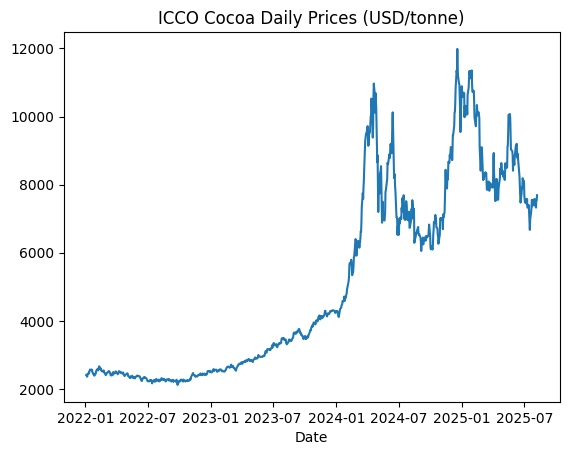

In [23]:
# Quick visual sanity check
df_sql.set_index("Date")["icco_daily_usd_per_tonne"].plot(
    title="ICCO Cocoa Daily Prices (USD/tonne)"
)

Advanced Analytics

In [24]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
# Load data from PostgreSQL into Python
df = pd.read_sql(
    f"SELECT * FROM {schema}.jl_cocoa_prices_2022_2025 ORDER BY \"Date\"",
    engine
)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
df.head()


,Date,london_futures_gbp_per_tonne,newyork_futures_usd_per_tonne,icco_daily_usd_per_tonne,icco_daily_eur_per_tonne,any_missing
0,2022-01-03,1702.17,2523.67,2406.58,2131.99,false
1,2022-01-04,1687.00,2502.67,2392.21,2117.94,false
2,2022-01-05,1691.67,2495.67,2394.70,2112.24,false
3,2022-01-06,1672.67,2456.33,2358.93,2086.59,false
4,2022-01-07,1720.67,2548.33,2441.38,2149.76,false


In [26]:
price_col = "icco_daily_usd_per_tonne"
s = df[price_col].astype(float)


To prepare the cocoa price data for statistical analysis, we transformed daily prices into percentage returns. This allows valid hypothesis testing, confidence interval estimation, and regression analysis.

In [31]:
# This computes the daily percentage change in cocoa prices:
df["return"] = df[price_col].pct_change()     # daily percent change

df[["Date", price_col, "return"]].head(10)

,Date,icco_daily_usd_per_tonne,return
0,2022-01-03,2406.58,NaN
1,2022-01-04,2392.21,-0.005971
2,2022-01-05,2394.70,0.001041
3,2022-01-06,2358.93,-0.014937
4,2022-01-07,2441.38,0.034952
5,2022-01-10,2438.54,-0.001163
6,2022-01-11,2490.14,0.021160
7,2022-01-12,2481.59,-0.003434
8,2022-01-13,2525.82,0.017823
9,2022-01-14,2567.27,0.016411


On average, cocoa traded around 5,074 USD per tonne in your study period.

Prices fluctuate widely around the mean (≈ ±2,800 USD), indicating large level variation driven by trends and shocks.

On average, cocoa prices increased by ~0.16% per day during this period.

Daily cocoa prices typically move by about ±2.6% per day.

During the period 2022–2025, cocoa prices averaged approximately USD 5,074 per tonne. However, the standard deviation of daily prices was high due to strong upward trends and market shocks. Daily returns averaged about 0.16%, indicating sustained price pressure, while daily volatility was approximately 2.6%, reflecting significant short-term uncertainty in the cocoa market.

In [28]:
variation = {
    "price_mean": df[price_col].mean(),
    "price_std": df[price_col].std(),
    "return_mean": df["return"].mean(),
    "return_std": df["return"].std(),  # daily volatility
}
variation


{'price_mean': np.float64(5073.862892741062),
 'price_std': np.float64(2796.873425688114),
 'return_mean': np.float64(0.001610448103778467),
 'return_std': np.float64(0.026210822996770657)}

While cocoa prices show an upward tendency, the short-term daily movements are highly volatile, making it difficult to statistically confirm a consistent daily increase.

In [29]:
x = df["return"].dropna().values
n = len(x)
mean = x.mean()
se = x.std(ddof=1) / np.sqrt(n)

alpha = 0.05
tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
ci = (mean - tcrit*se, mean + tcrit*se)

mean, ci


(np.float64(0.001610448103778467),
 (np.float64(-8.363376329150558e-05), np.float64(0.0033045299708484395)))

A one-sample t-test indicates a positive average daily return; however, the result is not statistically significant at the 5% level (p = 0.062).

In [30]:
tstat, pval = stats.ttest_1samp(df["return"].dropna(), popmean=0.0)
tstat, pval


(np.float64(1.8656558629738385), np.float64(0.062407266887306585))

Prices fluctuate daily, but the regression line shows a strong upward trend over time.

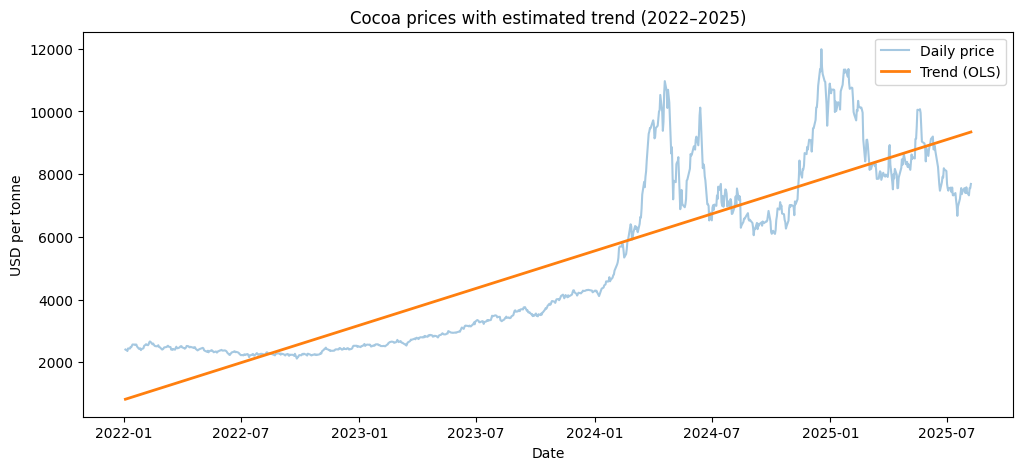

In [32]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

df_trend = df.dropna(subset=[price_col]).copy()
df_trend["t"] = (df_trend["Date"] - df_trend["Date"].min()).dt.days

X = sm.add_constant(df_trend["t"])
y = df_trend[price_col]
model = sm.OLS(y, X).fit()

df_trend["trend"] = model.predict(X)

plt.figure(figsize=(12,5))
plt.plot(df_trend["Date"], df_trend[price_col], label="Daily price", alpha=0.4)
plt.plot(df_trend["Date"], df_trend["trend"], label="Trend (OLS)", linewidth=2)
plt.title("Cocoa prices with estimated trend (2022–2025)")
plt.xlabel("Date")
plt.ylabel("USD per tonne")
plt.legend()
plt.show()


/var/folders/2x/d230_27s5m77vy1w0186q7n00000gn/T/ipykernel_80850/4189532795.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


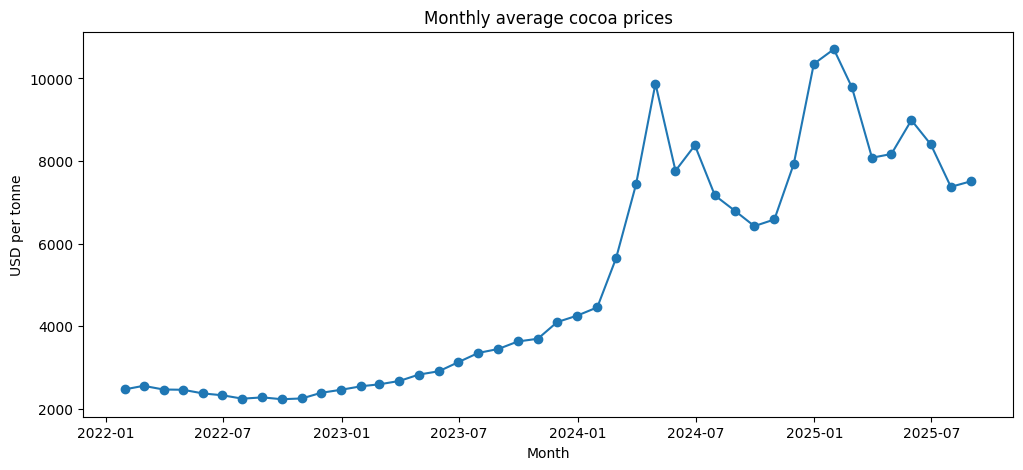

In [34]:
monthly = (
    df.set_index("Date")[price_col]
    .resample("M")
    .mean()
)

plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly.values, marker="o")
plt.title("Monthly average cocoa prices")
plt.xlabel("Month")
plt.ylabel("USD per tonne")
plt.show()
